# Deep Learning with Game Of Life, Part IIIb
# Multi-Layer Neural Net, Softmax Output Layer

The following is a modified version of [GOL_NN_ipynb](GOL_NN.ipynb) notebook. The modifications here consist of changes in the setup of train/test sets (using one-hot arrays instead of binary classification) and changes in the model implementation to use softmax for activation in the output layer.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as clrs

%matplotlib inline

# Import local utility functions
from utils import gol_utils as gol

## Create all possible permutations of 3x3 array
permutations = np.asarray([gol.bitfield(x) for x in range(0, (2**9))])

# Use a fixed seed for random ops to get uniform results in runs
np.random.seed(1)

## Prepare the sets for all combinations of pre/post iteration statuses, with a shuffled set
## To make sure that fully empty + fully populated scenarios are in the train set, first
## shuffle permutations 1-510 and then insert permutations 0 and 511 to the beginning of set
shuffled = permutations.copy()[1:len(permutations)-1:]
#shuffled = permutations.copy()
np.random.shuffle(shuffled)

#FIX the edge cases in
edge_cases = np.array([np.zeros_like(permutations[0]), np.ones_like(permutations[0])])
shuffled = np.concatenate((edge_cases, shuffled))

centers = np.asarray([(p[1][1]) for p in shuffled])
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in shuffled])

lived = shuffled[(1 == centers) & (1 == truths)]
spawned = shuffled[(0 == centers) & (1 == truths)]
died = shuffled[(1 == centers) & (0 == truths)]
empty = shuffled[(0 == centers) & (0 == truths)]
#Try with half the data for training, other half for testing (every second sample in each category)

#15 produces 100% accuracy
bias_spawned = int(spawned.shape[0] / 100 * 12)
bias_died = int(died.shape[0] / 100 * 12)
bias_lived = int(lived.shape[0] / 100 * 12 )
bias_empty = int(empty.shape[0] / 100 * 12 )

train_set_x = np.concatenate((empty[:bias_empty:],
                             spawned[:bias_spawned:],
                             died[:bias_died:],
                             lived[:bias_lived:]))

test_set_x = np.concatenate((empty[bias_empty::],
                            spawned[bias_spawned::],
                            died[bias_died::],
                            lived[bias_lived::]))

#one hot labeling
targets = np.concatenate((np.full([1, bias_empty], 0, dtype=int),
                             np.full([1, bias_spawned], 1,  dtype=int),
                             np.full((1, bias_died), 2, dtype=int),
                             np.full((1, bias_lived), 3, dtype=int)), axis=1).reshape(-1)
train_set_y = np.eye(4)[targets]
perms = len(permutations)

targets = np.concatenate((np.full([1, perms-bias_empty], 0, dtype=int),
                             np.full([1, perms-bias_spawned], 1, dtype=int),
                             np.full((1, perms-bias_died),2, dtype=int),
                             np.full((1, perms-bias_lived),3, dtype=int)), axis=1).reshape(-1)
test_set_y = np.eye(4)[targets]


# Flatten the train and test sets along the first axis (ending up with (9,m) sized arrays)
train_set_x_flat = train_set_x.reshape(train_set_x.shape[0], -1).T
test_set_x_flat = test_set_x.reshape(test_set_x.shape[0], -1).T



In [2]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache


def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    assert (dZ.shape == Z.shape)
    return dZ


def softmax(Z):
    cache = Z
    exp_scores = np.exp(Z)
    probs = exp_scores / (np.sum(exp_scores, axis=0, keepdims=True) + 1e-9)
    return probs, cache


def softmax_backward(dA, cache, y):
    num_examples = y.shape[0]
    dscores = dA.T
    dscores[range(num_examples), np.argmax(y, axis=1)] -= 1
    dscores /= num_examples
    return dscores.T


def tanh(Z):
    A = np.tanh(Z)
    cache = Z
    return A, cache


def tanh_backward(dA, cache):
    Z = cache
    output = np.tanh(Z)
    dZ = (1.0 - np.square(output)) * dA
    assert (dZ.shape == Z.shape)
    return dZ


def relu(Z):
    A = np.maximum(0, Z)
    assert (A.shape == Z.shape)
    cache = Z
    return A, cache


def relu_backward(dA, cache):
    Z = np.asarray(cache)
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ


def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)  # number of layers in the network
    np.random.seed(1)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters


def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters


def linear_forward(A, W, b, keep_prob):
    Z = np.dot(W, A) + b
    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b, keep_prob)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation, keep_prob=1):
    np.random.seed(1)
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b, keep_prob)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b, keep_prob)
        A, activation_cache = relu(Z)

    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b, keep_prob)
        A, activation_cache = tanh(Z)

    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b, keep_prob)
        A, activation_cache = softmax(Z)

    DO = np.random.rand(A.shape[0], A.shape[1])
    DO = DO < keep_prob
    A = A / keep_prob

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def linear_backward(dZ, cache, lambd=0.0):
    A_prev, W, b, keep_prob = cache
    m = A_prev.shape[1]

    dW = 1. / m * np.dot(dZ, A_prev.T) + (lambd * W) / m
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    db = np.sum(db)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (isinstance(db, float))

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation, truths, lambd=0.0, keep_prob=1):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)

    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache, truths)

    # Shorten the code
    dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)
    dA_prev = dA_prev / keep_prob

    return dA_prev, dW, db


def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters


def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2  
    v_corrected = {}  
    s_corrected = {}  

    # Perform Adam update on all parameters
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads['dW' + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads['db' + str(l + 1)]

        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))

        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.power(grads['dW' + str(l + 1)], 2)
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.power(grads['db' + str(l + 1)], 2)

        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))

        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v_corrected[
            "dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected[
            "db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)

    return parameters, v, s


def initialize_adam(parameters):
    L = len(parameters) // 2  # number of layers in the neural networks
    v = {}
    s = {}

    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])

    return v, s


def compute_cost(AL, Y):
    num_examples = Y.shape[0]
    corect_logprobs = -np.log(AL.T[range(num_examples), np.argmax(Y, axis=1)])
    data_loss = np.sum(corect_logprobs) / num_examples
    return data_loss


def compute_cost_with_regularization(AL, Y, parameters, lambd):
    m = Y.shape[0]
    L = len(parameters) // 2
    squared = 0.0
    for l in range(L):
        W = parameters["W" + str(l + 1)]
        squared = squared + np.sum(np.square(W))

    cross_entropy_cost = compute_cost(AL, Y)
    L2_regularization_cost = lambd * squared / (2 * m)

    cost = cross_entropy_cost + L2_regularization_cost
    return cost


def L_model_backward(AL, Y, caches, lambd=0.0, keep_prob=1):
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    dAL = AL

    current_cache = caches[L - 1]
    dA_g = "dA" + str(L)
    dW_g = "dW" + str(L)
    db_g = "db" + str(L)
    grads[dA_g], grads[dW_g], grads[db_g] = linear_activation_backward(dAL, current_cache, "softmax", Y, lambd)

    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)],
                                                                    current_cache,
                                                                    "tanh", lambd, keep_prob=keep_prob)
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads


def L_model_forward(X, parameters, keep_prob=1):
    caches = []
    A = X
    L = len(parameters) // 2 
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,
                                             parameters['W' + str(l)],
                                             parameters['b' + str(l)],
                                             activation='tanh', keep_prob=keep_prob)
        caches.append(cache)

    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          activation='softmax')
    caches.append(cache)
    assert (AL.shape == (4, X.shape[1]))
    return AL, caches


def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=5000, lambd=0.0,
                  print_cost=False):  # lr was 0.009
    costs = []  # keep track of cost
    trainhits = []
    testhits = []

    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost_with_regularization(AL, Y, parameters, lambd=lambd)
        grads = L_model_backward(AL, Y, caches, lambd)
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every nth training example
        if print_cost and i % int(num_iterations / 10) == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % int(num_iterations / 100) == 0:
            costs.append(cost)
            acc1, acc2 = currentAccuracies(parameters, '')
            trainhits.append(acc1)
            testhits.append(acc2)
            
    return parameters, costs, trainhits, testhits

def L_layer_model_adam(X, Y, layers_dims, learning_rate=0.001, num_iterations=10000,
                       beta1=0.9, beta2=0.999, epsilon=1e-8, lambd=0.0, print_cost=False, keep_prob=1):
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    v, s = initialize_adam(parameters)
    t = 0
    costs = []
    trainhits = []
    testhits = []

    for i in range(0, num_iterations):
        t = t + 1
        AL, caches = L_model_forward(X, parameters, keep_prob=keep_prob)
        cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
        grads = L_model_backward(AL, Y, caches, lambd, keep_prob=keep_prob)
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                       t, learning_rate, beta1, beta2, epsilon)
        # Print the cost every nth training example
        if print_cost and i % int(num_iterations / 5) == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % int(num_iterations / 100) == 0:
            costs.append(cost)
            acc1, acc2 = currentAccuracies(parameters, '')
            trainhits.append(acc1)
            testhits.append(acc2)

    return parameters, costs, trainhits, testhits

def predict(X, parameters, af='relu'):
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    # convert probas to 0..3 predictions
    y_pred = np.argmax(probas, axis=0)
    return y_pred

def currentAccuracies(parameters, af='relu'):
    preds_train = predict(train_set_x_flat, parameters, af)
    truths_train = np.asarray([(gol.life_step_standard_rules(p)[1][1] + (p[1][1]) * 2) for p in train_set_x])
    trainhit = np.sum((preds_train == truths_train)/train_set_x.shape[0])

    preds_test = predict(test_set_x_flat, parameters, af)
    truths_test = np.asarray([(gol.life_step_standard_rules(p)[1][1] + (p[1][1]) * 2) for p in test_set_x])
    testhit = np.sum((preds_test == truths_test)/test_set_x.shape[0])
    return trainhit, testhit

def plotGraph(datapack, title):
    costs, acc1, acc2 = datapack
    a,b,c = plt.plot(costs, 'black', acc1, 'b--', acc2, 'r--')
    plt.legend([a, b, c], ["Cost", "Train set accuracy", "Test set accuracy"], loc='lower left')
    plt.suptitle(title)
    axes = plt.gca()
    axes.set_ylim([0,np.maximum(max(costs), max(acc2))])
    ticks = np.arange(0, 100+1, 100/5)
    labels = np.arange(0, itrs+1, itrs/5, dtype=int)
    plt.xticks(ticks, labels)
    plt.xlabel("iterations")
    
    plt.ylabel("cost/accuracy")
    plt.show()

Cost after iteration 0: 1.395202
Cost after iteration 140: 0.502288
Cost after iteration 280: 0.407956
Cost after iteration 420: 0.269975
Cost after iteration 560: 0.297090
Train set accuracy: 1.0
Test set accuracy: 1.0
empty 200 200
spawned 56 56
died 172 172
lived 84 84


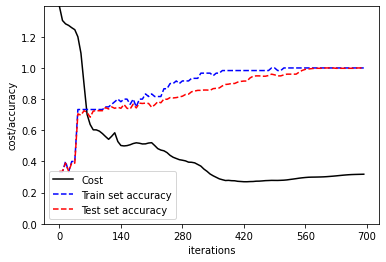

In [3]:
layers_dims = [9,512,200,4]
lambd = 0.1
lr = 0.006
itrs = 700
beta1 = 0.99
beta2 = 0.9997
epsilon = 0.00000001
kp = 0.3
fx='softmax'
opt='adam'

params, costs, acc1, acc2 = L_layer_model_adam(train_set_x_flat, train_set_y, layers_dims, num_iterations=itrs, learning_rate=lr, beta1=beta1, beta2=beta2, epsilon=epsilon, lambd=lambd, print_cost=True)

p_flat = permutations.reshape(permutations.shape[0], -1).T
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1]) for p in permutations])
predictions = predict(p_flat, params)

preds_train = predict(train_set_x_flat, params)
truths_train = np.asarray([(gol.life_step_standard_rules(p)[1][1] + (p[1][1]) * 2) for p in train_set_x])

print("Train set accuracy: "  + str(np.sum((preds_train == truths_train)/train_set_x.shape[0])))

preds_test = predict(test_set_x_flat, params)
truths_test = np.asarray([(gol.life_step_standard_rules(p)[1][1] + (p[1][1]) * 2) for p in test_set_x])
print("Test set accuracy: "  + str(np.sum((preds_test == truths_test)/test_set_x.shape[0])))

p_flat = permutations.reshape(permutations.shape[0], -1).T
truths = np.asarray([(gol.life_step_standard_rules(p)[1][1] + (p[1][1]) * 2) for p in permutations])
predictions = predict(p_flat, params)

print ("empty " + str(len(np.where(predictions==0)[0])) + " " + str(len(empty)))
print ("spawned " + str(len(np.where(predictions==1)[0])) + " " + str(len(spawned)))
print ("died " + str(len(np.where(predictions==2)[0])) + " " + str(len(died)))
print ("lived " + str(len(np.where(predictions==3)[0])) + " " + str(len(lived)))

# Plot learning curve (with costs)
res = np.array([costs, acc1, acc2])

accuracy = np.sum((preds_test == truths_test)/test_set_x.shape[0])
                 
## Save results to file
#if accuracy == 1:
#    foo = str(layers_dims).replace(', ','-') +'-' +str(lambd) + '-' +  str(lr) + '-' + str(itrs) + '-' + fx + '-' + opt
#    if opt=='adam':
#        foo = foo + '-' + str(beta1) + '-' + str(beta2) + '-' + str(epsilon)
#    np.savetxt(foo + '.txt', res)

# Plot learning curve (with costs and accuracy)
plotGraph(res, "")

### Animated side-by-side display

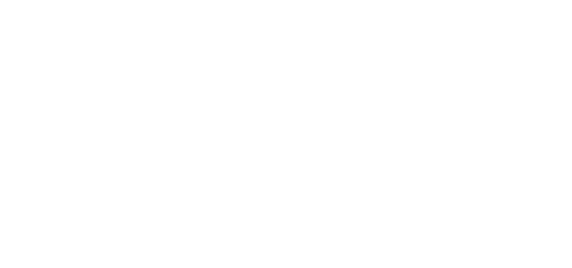

In [4]:
from IPython.display import HTML
from matplotlib import animation

# settings for the animation 
gridsize = 40
gens = 100
ival = 100

# Create a random game grid of 50% density 
GAME = np.random.randint(2, size=(gridsize,gridsize))
GAME_REF = GAME

def life_step_lr(GRID):
    GRID_STEP = np.zeros([gridsize, gridsize])
    #create rim around the game area for torus-like op 
    expGame = np.pad(GRID,[(1,1),(1,1)], mode='wrap')
    
    for x in range(1,gridsize+1):
        for y in range(1,gridsize+1):
            moore = expGame[x-1:x+2, y-1:y+2]
            moore_flat = moore.reshape(moore.shape[0] * moore.shape[1],1)
            GRID_STEP[x-1,y-1] = np.int(predict(moore_flat, params) % 2)
    return GRID_STEP

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.axis("off")
ax2.axis("off")
fig.set_size_inches(10, 5)

ims = []

#render generations
for g in range(0,gens):
    GAME = life_step_lr(GAME)
    GAME_REF = gol.life_step_standard_rules(GAME_REF)
    im = ax1.imshow(GAME, animated=True)
    im2 = ax2.imshow(GAME_REF, animated=True)
    ims.append([im, im2])

anim = animation.ArtistAnimation(fig,ims,interval=ival)
HTML(anim.to_html5_video())